This model is taken from this [source](https://homepages.inf.ed.ac.uk/rsarkar/papers/periodic.pdf). It defines a model of discrete signals with approximately periodic sequences embedded in them. It includes a periodic component with probabilistic inter-event time, and a Poisson process modeling the aperiodic false positive noise events. 

Let $y_{1:n} = y_1, y_2, ..., y_n$ be our observed periodic signal. This can be decomposed into the following two components: 

- A sequence of periodic events $x_{i}$ where $x_{i+1} = N(x_i + T, \sigma)$. Each signal event displays periodicity of time, $T$, along with gaussian noise parameterised by variance $\sigma^2$.
- A sequence of noise events $z_i$ where $z_{i+1} = z_i + \delta$, and $\delta$ follows an exponential distribution with an expectation of $\frac{1}{\lambda}$, for a rate parameter $\lambda > 0$. This component takes into account noise attributed with the signal reading that can come from the signal itself or the instrument used to detect the signal. 

The model would be able to tell us the periodicity of the signal, $T$, along with $\sigma$ and $\lambda$ in order to characterise the level of noise in the system. 

Let's first make the test data that will be used to validate our model. Some test cases that we can consider are: 

1. Just noise, no periodic signal: Can the model correctly identify that there is no signal?
2. Strict periodic signal with no noise: baseline, the model should be able to correctly infer the peridicity of the signal with 100% certainty. 
3. Signal with probabilistic period.
4. Periodic signal with phase drift. 
5. Periodic signal with random false positives.

In [64]:
import numpy as np
import matplotlib.pyplot as plt
SEED = 42 

In [52]:
# static class for saving the test data into
class TestData:
    NumTimesteps = 1000
    just_noise = None
    strict_periodicity = None 

test_data = TestData()

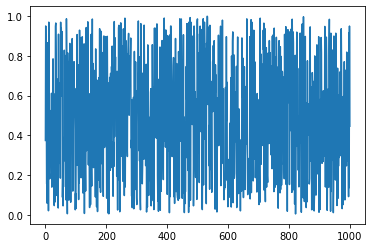

In [66]:
'''Signal with just noise'''

def get_signal_no_noise(N:int):
    rnd = np.random.RandomState(SEED)
    return rnd.rand(N)

test_data.just_noise = get_signal_no_noise(test_data.NumTimesteps)

plt.plot(test_data.just_noise)
plt.show()

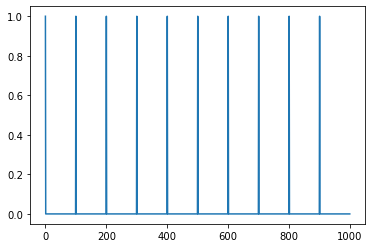

In [54]:
'''Signal with strict periodicity and no noise'''

def get_signal_strict_periodicity(N:int):
    amplitude = 1
    T = 100 
    strict_periodicity = np.zeros(N)

    # not going to bother handling for index out of range exception
    for i in range(int(N / T)):
        strict_periodicity[T * i] = amplitude

    return strict_periodicity

test_data.strict_periodicity = get_signal_strict_periodicity(test_data.NumTimesteps)

plt.plot(test_data.strict_periodicity)
plt.show()



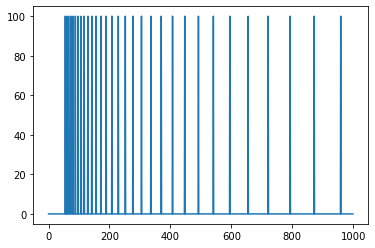

In [55]:
'''Strict periodic signal with phase drift'''

def get_signal_with_drift(N:int):
    amplitude = 100
    T = 50
    delta = 1.1
    signal = np.zeros(test_data.NumTimesteps)
    while True:
        try:
            T *= delta 
            signal[int(T)] = amplitude
        except IndexError:
            break 

    return signal

test_data.signal_with_drift = get_signal_with_drift(test_data.NumTimesteps) 
plt.plot(test_data.signal_with_drift)
plt.show()



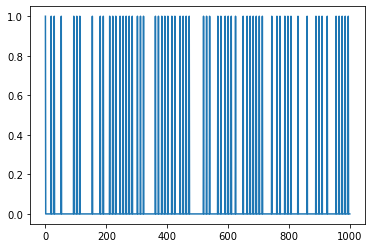

In [69]:
'''signal with probabilistic period'''

def get_signal_with_probabilistic_period(N:int):
    rnd = np.random.RandomState(SEED)
    amplitude = 1
    T = 10
    sigma = 20
    signal = np.zeros(test_data.NumTimesteps)
    
    t = 0
    while True: 
        try:
            signal[int(t)] = amplitude
            # use max as normal sampling can be negative
            t = T + max(t, t + rnd.normal(0, sigma))
        except IndexError: 
            break
    
    return signal



test_data.signal_with_probabilistic_period = get_signal_with_probabilistic_period(test_data.NumTimesteps)

plt.plot(test_data.signal_with_probabilistic_period)
plt.show()



Now that we have created our test data, let's implement the actual model. We will try and keep the variable naming consistent with the original [paper](https://homepages.inf.ed.ac.uk/rsarkar/papers/periodic.pdf). 

$$h_n = [T, \sigma^2, \lambda, \hat{z_i}^j, \hat{x_i}^j]^T$$

where $i$ is the $i$ th timestep, and $j$ refers to the $j$ th particle that we have sampled, and: 
- T : period of signal
- $\sigma$ : standard deviation for Gaussion distribution of period variability. 
- $\lambda$ : Rate of false positive noise events.
- $\hat{z}$ : Latest event timestep marked as a noise event.
- $\hat{x}$ : Latest event timestep marked as a periodic event. 

Each observed signal value $y_i$ can be classified as either the periodic signal or false positive noise. The model will therefore use variable $r_i$ where:
$r_i = 1$ if $y_i$ originates from the periodic process, $r_i = 0$ otherwise. 

### Likelihood functions

#### 1. Likelihood function for signal, $L = p(y_i | h_i)$

$L = p(y_i | h_i) = \sum_{r \in {0,1}}p(y_i, r_i | h_i)$

Let's inspect the first component of the summation when $r_i = 1$. This component is the likelihood of the signal when it is generated by the periodic signal process. 

$p(y_i, r_i = 1 | h_i) = p(y_i | h_i, r_i = 1)p(r_i = 1)$

and $p(y_i | h_i, r_i = 1)$ refers to the likelihood of the signal given it is generated by the periodic signal process. As mentioned above, we model this using Gaussian distribution centered about the timestamp of the last identified signal process offset by the period, $x_{i-1} + T_i$, with noise $\sigma_i$:

$p(y_i | h_i, r_i = 1) = N(T_i + \hat{x}_{i-1}, \sigma_i)$

The term $p(r_i = 1)$ refers to the probability of $y_i$ not being a noise event. 

This is equivalent to: $1 - p(r_i = 0)$

Given the false positive signal generation process follows a Poisson distribution, $p(r_i = 0)$ is equivalent to the probability that $y_i$ is the first noise process to be identified between the last identified false positive $z_{i-1}$ and $y_i$. The time between poission events is modelled by the exponential distribution, and the CDF of said distribution is $F(x) = 1 - exp(-\lambda x)$. Hence, $1 - F(x) = exp(\lambda x)$

$$1 - p(r_i = 0) = 1 - F(y_i - z_{i-1}; exp(\lambda_i)) = exp(\lambda (y_i - z_{i-1}))$$ 

Now, let's inspect the second term of the summation when $r_i = 0$. This component is the likelihood of the signal when it is a false positive generated by noise. By definition of conditional probabilities, this can be rewritten as below: 

$$p(y_i, r_i = 0 | h_i) = p(y_i | r_i = 0, h_i) p(r_i = 0)$$

We already have the second term, modelled by an exponential distribution $f_{\exp}(x) = \lambda exp(-\lambda x)$. 

The first term is equivalent to the probability of no peridic signal event being detected between the last detected signal timestamp, $\hat{x}_i$, and current signal timestamp $y_i$. This is approximated by the complementary cumulative density of periodic events between $\hat{x}_i$ and $y_i$ - $1 - \Phi(T_i + \hat{x}_{i-1}, \sigma_i)$, where $\Phi(x) = P(X < x)$ is the Gaussian CDF. 

In [8]:
import numpy as np
from enum import Enum
from dataclasses import dataclass
from scipy.stats import norm, expon

@dataclass
class Config:
    '''
    Configuration object for periodicity particle filter
    Args: 
        signal: the signal to be analyse
        num_particles: number of particles to use
        prior_T_scale: the hyperparameter to be used for the exponential distribution 
        that is used as the prior distribution for period T. 
        prior_lambda_scale: the hyperparameter to be used for the exponential distribution 
        that is used as the prior distribution for noise event rate Lambda.
        x_0: initial value for periodic event variable
        z_0: initial value for noise event variable
        cauchy_scale: scale parameter for cauchy distribution used as the hypothesis distribution
    '''
    signal : list
    num_particles : int = 50
    prior_T_scale : float = 1.0
    prior_lambda_scale : float = 1.0
    x_0: float = 0.0 
    z_0: float = 0.0
    cauchy_scale : float = 1.0

    def __post_init__(self):
        self.num_timesteps = len(self.signal)

@dataclass
class Particles:
    '''
    Dataclass for carrying around each variable defined in particle vector 
    h = [T, lambda, sigma, xhat, zhat]^t. 
    
    Args: 
        T: 
        Lambda: Rate parameter for false positive signals due to noise. 
    '''
    T : "np.ndarray"
    Lambda : "np.ndarray"
    Sigma : "np.ndarray"
    X : "np.ndarray"
    Z : "np.ndarray"

    # timestamp of last identified signal generated by periodic signal process
    _X_last : "np.ndarray" = None 

    # timestamp of last identified signal generated by false positive noise process
    _Z_last : "np.ndarray" = None

    def __post_init__(self):

        # enforce type checking as a simple list does not support broadcasting
        # user must provide numpy arrays 
        assert isinstance(self.T, np.ndarray), "T is not a numpy array"
        assert isinstance(self.Lambda, np.ndarray), "Lambda is not a numpy array"
        assert isinstance(self.Sigma, np.ndarray), "Sigma is not a numpy array"
        assert isinstance(self.X, np.ndarray), "X is not a numpy array"
        assert isinstance(self.Z, np.ndarray), "Z is not a numpy array"

    @property
    def X_last(self):
        return self._X_last

    @X_last.setter
    def X_last(self, val):
        '''enforce type checking as a simple list does not support broadcasting
        user must provide numpy arrays'''
        assert isinstance(val, np.ndarray), "X_last is not a numpy array"
        self._X_last = val 

    @property
    def Z_last(self):
        return self._Z_last

    @Z_last.setter
    def Z_last(self, val):
        '''enforce type checking as a simple list does not support broadcasting
        user must provide numpy arrays'''
        assert isinstance(val, np.ndarray), "X_last is not a numpy array"
        self._Z_last = val


    def as_matrix(self):
        '''Return np.ndarray of vector h = [T, lambda, sigma, xhat, zhat]^t
        of shape (5, num_particles)'''
        return np.stack((self.T, self.Lambda, self.Sigma, self.X, self.Z))

class PeriodicityParticleFilter:
        
    # enum class for variable indexing
    class VariableIndex(Enum):
        T = 0
        Lambda = 1
        Sigma = 2
        X = 3
        Z = 4

    def __init__(self, config:Config):
        self.config = config
        self.num_timesteps = self.config.num_timesteps
        self.K = self.config.num_particles
        self.s_T = self.config.prior_T_scale 
        self.s_lambda = self.config.prior_lambda_scale
        self.s_cauchy = self.config.cauchy_scale

    def initialise_samples(self) -> Particles:
        '''
        Sample K particles from prior distributions for h_0
        h = [T, lambda, sigma] 
        where: 
            T ~ exponential(scale) 
            lambda ~ exponential(scale)
            sigma ~ Uniform(0, T)
            x_0 = zero
            z_0 = zero
        '''
        T_0 = np.random.exponential(self.s_T, self.K)
        lambda_0 = np.random.exponential(self.s_lambda, self.K) 
        sigma_0 = np.random.rand(self.K) * T_0
        x_0 = np.zeros(self.K)
        z_0 = np.zeros(self.K) 
        return Particles(T_0, lambda_0, sigma_0, x_0, z_0)

    def sample_cauchy_1D(loc, scale):
        hnew_std = np.random.standard_cauchy(len(loc))
        hnew = scale * hnew_std + loc 
        return hnew

    def update_hypothesis(self, h:Particles):
        '''
        Sample next set of particles from hypothesis distribution p(h_i|h_{i-1}).
        For the ith timestep, let j denote the jth particle:
        h^j = [T^j, lambda^j, sigma^j, x_j, z_j]

        where each variable in vector h_j are sampled from a cauchy distribution centred
        about the previous particle value. 
        '''
        # sample T, lambda, sigma from cauchy
        # hnew_std = np.random.standard_cauchy() # scale = s, mean = 0
        # hnew = self.s_cauchy * hnew_std + h # scale = s, mean = h

        Tcurr = h.T
        sigma_cur = h.Sigma
        lambda_curr = h.Lambda

        h.T = self.sample_cauchy_1D(h.T, self.s_cauchy)
        h.Sigma = self.sample_cauchy_1D(h.Sigma, self.s_cauchy)
        
        # we need to adjust for noise rate param lambda as this needs to be greater than zero
        h.Lambda = self.sample_cauchy_1D(h.Lambda, self.s_cauchy).clip(min=0)

        # doing these are a bit more complicated. Look in section 3.2 - Hypothesis Updates. 
        x_new = None 
        z_new = None
        
        return None

    def get_periodic_likelihood(self, y, h:Particles):
        '''
        The likelihood of the signal being generated by the signal process. 

        L = p(yi, ri=1|hi) = p(yi | hi, ri = 1) x (1 - p(ri = 0)) 
        = N(Ti + x_{i-1}, sigma_i) * (1 - F(yi - z_{i-1}; exp(lambda_i)))

        Args: 
            y : ith event timestamp
            h : particle object containing current parameter hypotheses 
        '''
        
        # p(yi | hi, ri=1) = N(Ti + x_{i-1}, sigma_i)
        p1 = norm.pdf(y, h.T + h.X_last, h.Sigma)
        
        # 1 - F(yi - z_{i-1}; exp(lambda_i)); F_exp(x; lambda) = 1 - exp(-lamba * x)
        # therefore, 1 - F(yi - z_{i-1}; exp(lambda_i)) = exp(-lambda * (yi - z_{i-1}))
        p2 = np.exp(-h.Lambda * (y - h.Z_last))

        return p1 * p2 

    def get_false_positive_likelihood(self, y, h:Particles):
        '''
        The likelihood of the signal being a false positive generated by noise. 

        L = p(yi, ri = 0 | hi) = p(i | hi, ri = 0) x p(ri = 0) 
        = f(yi - z_{i-1}; exp(lambda_i)) * (1 - F(yi; N(x_{i-1} + Ti, sigma_i)))

        Args: 
            y: ith event timestamp
            h: particle object containing current parameter hypotheses. 
        '''
        # f(yi - z_{i-1}; exp(lambda_i)), expon takes parameter scale = 1/lambda
        p1 = expon.pdf(y - h.Z_last, 1 / h.Lambda)
        
        # 1 - Phi(y; x_{i-1} + Ti, sigma_i)
        p2 = 1 - norm.cdf(y, loc = h.T + h.X_last, scale = h.Sigma)

        return p1 * p2 

    def likelihood_weighting(self, h):

        # Lper = p(yi, ri=1 | hi)
        Lperiodic = self.get_periodic_likelihood()

        # Lfp = p(yi, ri0 | hi)
        Lfp = self.get_false_positive_likelihood()

        # L = p(yi | hi) = p(yi, ri=0 | hi) + p(yi, ri=1 | hi)
        L = Lperiodic + Lfp
        
        return L


    def fit(self):
        '''Run the particle filter on the input data.'''

        # initialise K particles by sampling from prior distributions 
        # over hypothesis parameters. 
        h_0 = self.initialise_samples()

        for t in range(self.num_timesteps):

            # sample next set of particles from hypothesis distribution p(h_i|h_{i-1})

            # likelihood weighting - compute likeliness of each particle

            pass
        

        pass 


In [9]:
### unit tests ## 

# Test function - get_periodic_likelihood

def test_periodic_likelihood_no_noise():
    '''
    Test case: 

    Let's have the signal as strictly periodic where the true
    period T = 100;
    
    i.e. signal timestamps = 0, 100, 200, 300, 400, 500,...

    Here, true lambda = 0 (rate of false positive = 0 as we have none)
    and true sigma = 0 (signal is strictly periodic with no uncertainty)

    For our particle vector h = [T, lambda, sigma, X, Z], let's have the following samples: 

    For this test case, y_{i-1} = 100, y_i = 200

    particles for test scenario: 

    h1 = [T = 100, lambda = 0, sigma = 0, x_last = 100, z_last = 0]
    This should return NaN. T = 100 is correct with zero uncertainty. sigma=0, so gaussian pdf 
    would have an infinite pdf value. Lambda = 0 so correct that we have no noise, and we also
    correctly know no noise has been found yet, z_last = 0. 

    h2 = [T = 100, lambda = 0, sigma = 0.01, x_last = 100, z_last = 0]
    Same as test 1, but now with non-zero uncertainty. This should return a non-NaN likelihood value 
    as the gaussian no longer has a divide by zero. Exact value is: 39.89422804
    
    h3 = [T = 1, lambda = 0, sigma = 0.01, x_last = 100, z_last = 0]
    T is way off, with small uncertainty. x_last = 100 while current value is 200. 
    This means likelihood of the observation generated by a periodic signal according to particle h3 is zero. 
    Again, noise process param lambda is set to zero. 

    h4 = [T = 90, lambda = 0, sigma = 25, x_last = 100, z_last = 0]
    T is a bit off, but sigma = 25 so that actual T falls within 1 std dev of our estimate. 
    Likelihood should be moderate value. Actual value is 0.014730805
    '''
    y_prev = 100
    y_curr = 200
    example_T = np.array([100, 100, 1, 90])
    example_lambda = np.array([0, 0, 0, 0])
    example_sigma = np.array([1e-19, 0.01, 0.01, 25])
    example_X_last = np.array([y_prev, y_prev, y_prev, y_prev])
    example_Z_last = np.array([0, 0, 0, 0])
    
    example_h = Particles(example_T, 
                         example_lambda, 
                         example_sigma, 
                         np.zeros(3), # X_curr not used in priodic likelihood so just set to zero 
                         np.zeros(3)) # Z_curr not used in priodic likelihood so just set to zero

    example_h.X_last = example_X_last
    example_h.Z_last = example_Z_last

    # initialisation does not matter, we're just testing the get_periodic_likelihood func. 
    particle_filter = PeriodicityParticleFilter(Config([]))

    p = particle_filter.get_periodic_likelihood(y_curr, example_h)

    p1, p2, p3, p4 = p 
    p1_expected, p2_expected, p3_expected, p4_expected = 18.6, 39.9, 0, 0.014731

    assert np.round(np.log10(p1), 1) == p1_expected, f"Expected {p1_expected} for test case 1, but received {p1}"
    assert np.round(p2, 1) == p2_expected, f"Expected {p2_expected} for test case 2, but received {p2}"
    assert np.round(p3, 12) == p3_expected, f"Expected {p3_expected} for test case 3, but received {p3}"
    assert np.round(p4, 6) == p4_expected, f"Expected {p4_expected} for test case 4, but received {p4}"


def test_periodic_likelihood_with_noise():
    '''
    Test case: 

    Let's have the signal as periodic where the true period T = 100,
    with noise that occurs within 25 time units. Example signal could look like:
    
    i.e. signal timestamps = 0, 10, 100, 117, 200, 214, 300, 313, 400, 415, 500,...

    For our particle vector h = [T, lambda, sigma, X, Z], let's have the following samples: 

    h1 = [T = 100, lambda = 1/14. sigma = 1E-19, x_last = 200, z_last = 114]
    We set the particle T = 100 and sigma = 1E-19 - i.e. this particle is close to the actual true signal
    parameters. We set rate of false positivev as one-in-fourteen, i.e. you would expect to see a false positive
    once in every 14 timesteps. We've set the current and last noise signal times to be 114 and 214 respectively
    to reflect this. We should get a high likelihood for the periodic series in addition to a high 
    likelihood for the false positive signal. 
    '''
    z_last = 114
    y_prev = 200
    y_curr = 214

    example_T = np.array([100])
    example_lambda = np.array([1/100])
    example_sigma = np.array([1e-19])
    example_X_last = np.array([y_prev])
    example_Z_last = np.array([z_last])

    example_h = Particles(example_T, 
                         example_lambda, 
                         example_sigma, 
                         np.zeros(3), # X_curr not used in priodic likelihood so just set to zero 
                         np.zeros(3)) # Z_curr not used in priodic likelihood so just set to zero

    example_h.X_last = example_X_last
    example_h.Z_last = example_Z_last

    # initialisation does not matter, we're just testing the get_periodic_likelihood func. 
    particle_filter = PeriodicityParticleFilter(Config([]))

    p_periodic = particle_filter.get_periodic_likelihood(y_curr, example_h)
    p_fp = particle_filter.get_false_positive_likelihood(y_curr, example_h)

    print(p_periodic)
    print(p_fp)

    pass 

test_periodic_likelihood_with_noise()



[0.]
[4.47377931e-38]


In [6]:
def execute_all_tests():    
    test_periodic_likelihood_no_noise()
    test_periodic_likelihood_with_noise()

execute_all_tests()

[0.]
[1.]
